# Google Art & Culture - Case study using CRISPS-DM

#### Autors: Manuel Alejandro Aponte, Cristian Beltran, Maria Paula Peña

In this notebook you will explore data and create classification models

## Objectives
The objective of this notebooks is:

* Visualize the data through graphs.
* test different classification model based in dataset
* Optimize model by means of hyperparameters.

## Prerequisites

* Familiarity with Python, Sklearn & Grid Search. 
* Install python packages.

## Background 
This notebook belongs to Google Art & Culture Case Study using CRIPS-DM, where would be include process such as webscraping, exploratory data analysis, ML classificators and dashboards.



In [1]:
%load_ext autoreload
%autoreload 2

## Libraries 📚

In [63]:
#Import global packages
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

#Import local packages
from src.paths.paths import PATHS, create_folder

#Configure print settings
np.set_printoptions(precision=3, suppress=True)
warnings.filterwarnings("ignore")

## Load data

In [90]:
df = pd.read_csv( PATHS['data_final'] /"pictures.csv")
df.head(5)

,index,category,filename,Title,Date Created,Dimensions,Artist,h_mean,s_mean,v_mean,mean_grayscale,mean_blue,mean_green,mean_red,std_grayscale,std_blue,std_green,std_red
0,0,WHITE,0.jpg,"Symphony in White, No. 1 The White Girl",1862,overall 213 x 107.9 cm (83 7/8 x 42 1/2 in.) ...,James McNeill Whistler,0.111021,0.228014,0.759860,0.707468,0.592548,0.702255,0.759860,0.113919,0.112658,0.117957,0.108062
1,1,WHITE,1.jpg,The Cradle,1872,w460 x h560 cm,Berthe Morisot,0.114576,0.181637,0.627300,0.591144,0.519539,0.586287,0.626952,0.204013,0.186520,0.203947,0.212146
2,2,WHITE,2.jpg,The Magpie,1868 - 1869,w1300 x h890 mm,Claude Monet,0.166317,0.100085,0.706963,0.687141,0.638097,0.687555,0.704309,0.133684,0.122419,0.133433,0.139909
3,3,WHITE,3.jpg,Summer evening on Skagen Sønderstrand,1893,100 × 150 cm,Peder Severin Krøyer,0.355944,0.136984,0.745947,0.696685,0.713158,0.700890,0.682375,0.119145,0.071436,0.113651,0.153838
4,4,WHITE,4.jpg,"Composition with red, yellow and blue",1927,40 x 52 cm,Piet Mondriaan,0.152400,0.134496,0.874091,0.836621,0.802547,0.829830,0.862469,0.246921,0.279878,0.261812,0.241762


In [94]:
features_columns = ['h_mean','s_mean','v_mean','mean_grayscale','mean_blue','mean_green','mean_red','std_grayscale','std_blue','std_green','std_red']
target = ['category']

In [95]:
y = df[target]
X = df[features_columns] 

# Preprocesing Data

**Apply encoding to categories and scale features**

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#Create preprocessing objects
le = LabelEncoder()
sc = StandardScaler()

#Transform categories into nominal data
le.fit(y)
y=le.transform(y)

#Apply Standard Scaler to X
scaler = sc.fit(X)
X[features_columns] = scaler.transform(X[features_columns])

**Export label_encoder and Scaler**

In [7]:
dump(le, PATHS['models']/'label_encoder.joblib')
dump(le, PATHS['models']/'scaler.joblib')



['d:\\Portfolio\\Engineer\\computer science\\machine_learning_git\\clasification\\Google Art and Culture\\models\\scaler.joblib']

# EDA 📊

**Explore RGB features**

NOTE: Consider substitute for violin diagram

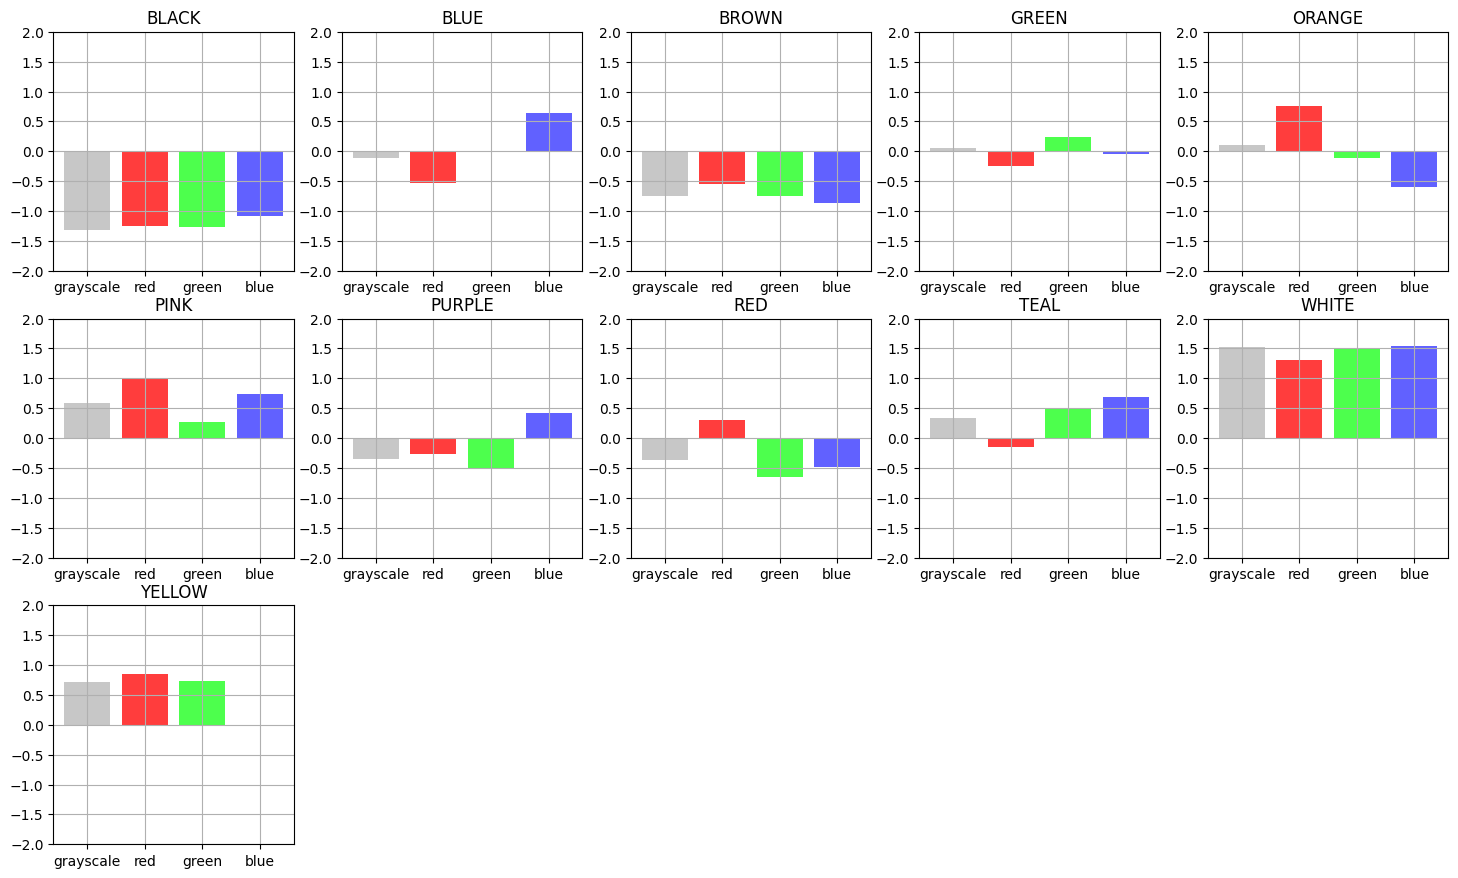

In [119]:
plt.figure(figsize=(18, 18))

categories = le.classes_
categories_encoding = le.transform(categories)

for category_encoding,category in zip(categories_encoding,categories):
    category_df = X.loc[np.where(y==category_encoding)]
    color_values = category_df[['mean_grayscale','mean_red', 'mean_green','mean_blue']].mean()
    plt.subplot(5, 5, category_encoding+1)
    plt.ylim(-2, 2)
    plt.grid(True)
    plt.bar(['grayscale','red','green','blue'],color_values ,color =['#C7C7C7','#FF3D3D','#4DFF4D','#6161FF'])
    plt.title(category)





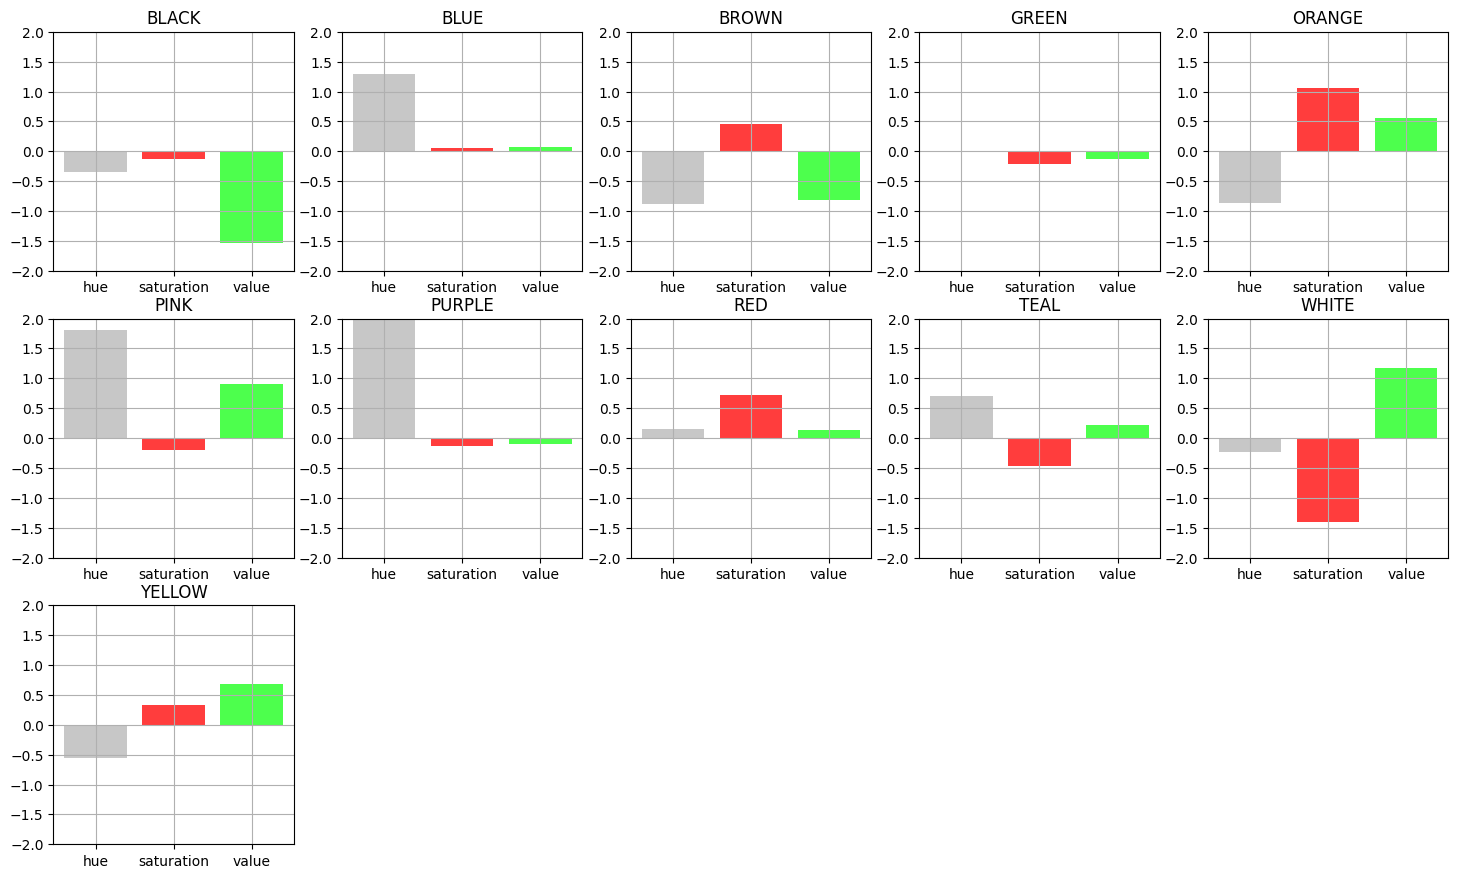

In [120]:
plt.figure(figsize=(18, 18))

for category_encoding,category in zip(categories_encoding,categories):
    category_df = X.loc[np.where(y==category_encoding)]
    color_values = category_df[['h_mean','s_mean', 'v_mean']].mean()
    plt.subplot(5, 5, category_encoding+1)
    plt.ylim(-2, 2)
    plt.grid(True)
    plt.bar(['hue','saturation','value'],color_values ,color =['#C7C7C7','#FF3D3D','#4DFF4D','#6161FF'])
    plt.title(category)


# EDA

Text(0.5, 1.0, 'Features correlation')

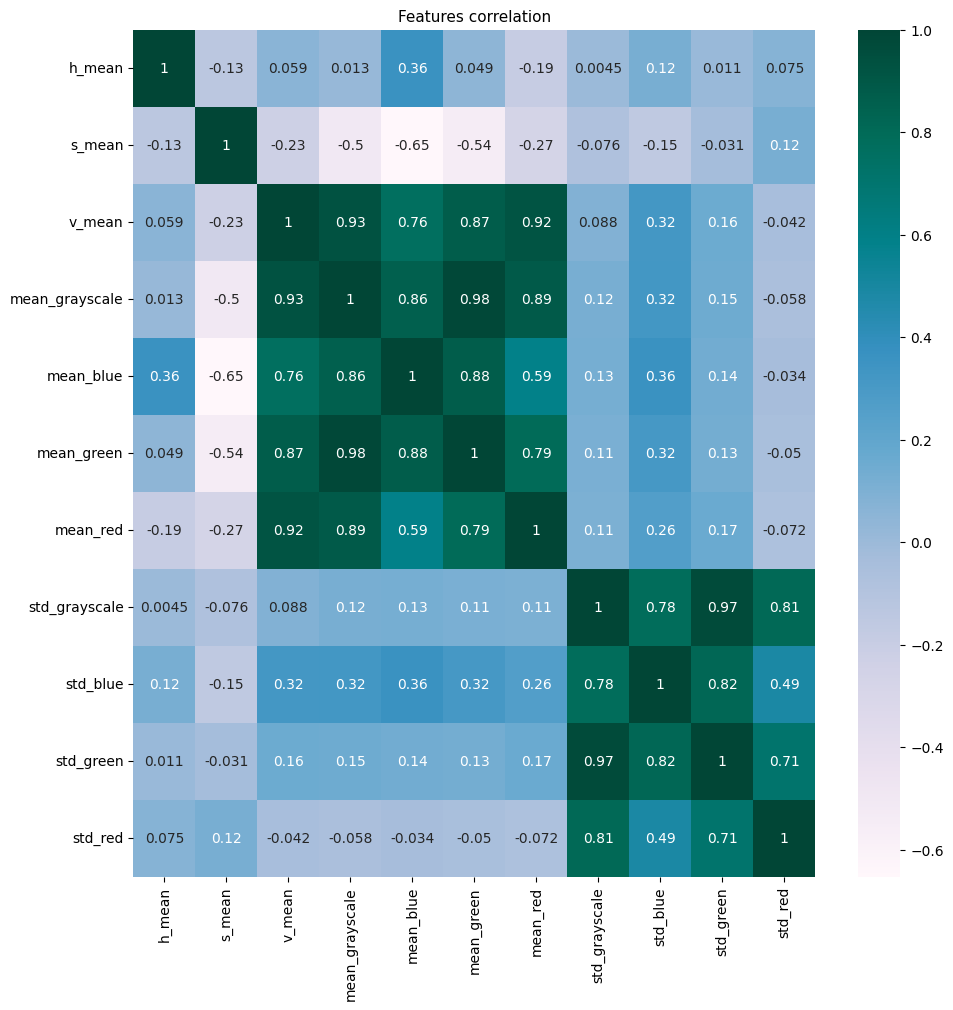

In [123]:
plt.figure(figsize=(11,11))
hm=sns.heatmap(X.corr(),cmap="PuBuGn",annot=True)
hm.set_title('Features correlation', fontdict={'fontsize':11})

### Considerations

* mean_grayscale and std_grayscale produces high correlation (>0.97) with other features, so that this two features will be deleted

In [127]:
X =X.drop(['mean_grayscale','std_grayscale'],axis=1)

## Models 📈

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#Consider extra parameters in KNN, logistic regression and NN
#Consider Store only the best estimator instead complete GridSeachCV object
def model_pipeline(X, y,n_jobs):
    default_params = {'random_state':42}    
    log_reg = LogisticRegression(**default_params|{'n_jobs':-1})
    knn = KNeighborsClassifier()
    svm = SVC(**default_params)
    NN = MLPClassifier(**default_params|{'hidden_layer_sizes':(526,526),'max_iter':400,'activation':'relu'
                        ,'n_iter_no_change':400,'learning_rate':'adaptive','batch_size':1000
                        ,'validation_fraction':0.15,'early_stopping':True})


    '''
    SUGGEST
        ('svm', svm, {'C': np.logspace(-1, 4, num=4),'gamma': np.logspace(-4, 0, num=5), 'kernel':['rbf','poly']}),
    RTA: Larger C numbers is extremly low    
    '''

   
    models = [
            ('logistic_regression', log_reg, {"penalty":['l2','none'], 'C':np.logspace(-4, 2, num=2)}), 
            ('k_nearest_neighbors', knn, {'n_neighbors':[3,9,12], 'metric': ['l1','l2']}), 
            ('svm', svm, {'C': np.logspace(-1, 5, num=7),'gamma': np.logspace(-4, 0, num=5), 'kernel':['rbf','linear']}),
            ('neural_network',NN, {'alpha':[0.5]} )
            ]
    
    results = pd.DataFrame(columns=['model','params','mean_test_score'])
    for name,model,params in models:
        print('Training:',name)
        classifier = GridSearchCV(model,params,cv=3,return_train_score=False,n_jobs=n_jobs,verbose=3)
        classifier.fit(X,y)
        full_report = pd.DataFrame(classifier.cv_results_)
        full_report['model']= name
        report = full_report[['model','params','mean_test_score','mean_fit_time','rank_test_score']]
        results = pd.concat([results, report])
        
        model_export_name = f'{name}.joblib'
        dump(classifier, PATHS['models']/model_export_name)
        
        '''
        SUGGEST
        svm_model = load(PATHS['models']/'svm.joblib').best_estimator_
        model_export_name = f'{name}.joblib'
        dump(classifier, PATHS['models']/model_export_name)
        
        '''
        
    results = results.reset_index(drop=True)
    return results


In [129]:
print('------All features------')
model_df = model_pipeline(X,y,2)

------All features------
Training: logistic_regression
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Training: k_nearest_neighbors
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Training: svm
Fitting 3 folds for each of 70 candidates, totalling 210 fits
Training: neural_network
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [131]:
model_df.to_csv(PATHS['models']/'report.csv',index = False)

# Model Selection

**Show the best models/params in the cross validation process** 

In [146]:
model_df.sort_values('mean_test_score',ascending=False).head(15)

,model,params,mean_test_score,mean_fit_time
72,svm,"{'C': 100000.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.847477,2.735592
54,svm,"{'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.845436,0.638967
64,svm,"{'C': 10000.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.841645,2.084834
62,svm,"{'C': 10000.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.841548,0.704675
80,neural_network,{'alpha': 0.5},0.839506,95.983416
44,svm,"{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.836104,0.412359
74,svm,"{'C': 100000.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.834062,13.768380
70,svm,"{'C': 100000.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.832993,0.761805
46,svm,"{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.831729,0.540672
36,svm,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.830368,0.405327


### Search the best models for each supervised technique

In [133]:
model_df.loc[model_df.groupby('model')['mean_test_score'].idxmax()].sort_values('mean_test_score',ascending=False)

,model,params,mean_test_score,mean_fit_time
72,svm,"{'C': 100000.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.847477,2.735592
80,neural_network,{'alpha': 0.5},0.839506,95.983416
1,logistic_regression,"{'C': 0.0001, 'penalty': 'none'}",0.818412,0.214668
6,k_nearest_neighbors,"{'metric': 'l1', 'n_neighbors': 12}",0.711772,0.011666


**The model with best result is SVM with params `{'C': 100000.0, 'gamma': 0.001, 'kernel': 'rbf'}`**

# Show metric for SVM model

In [143]:
svm_model = load(PATHS['models']/'svm.joblib').best_estimator_

In [147]:
X_train,X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y,random_state=32)


0
1


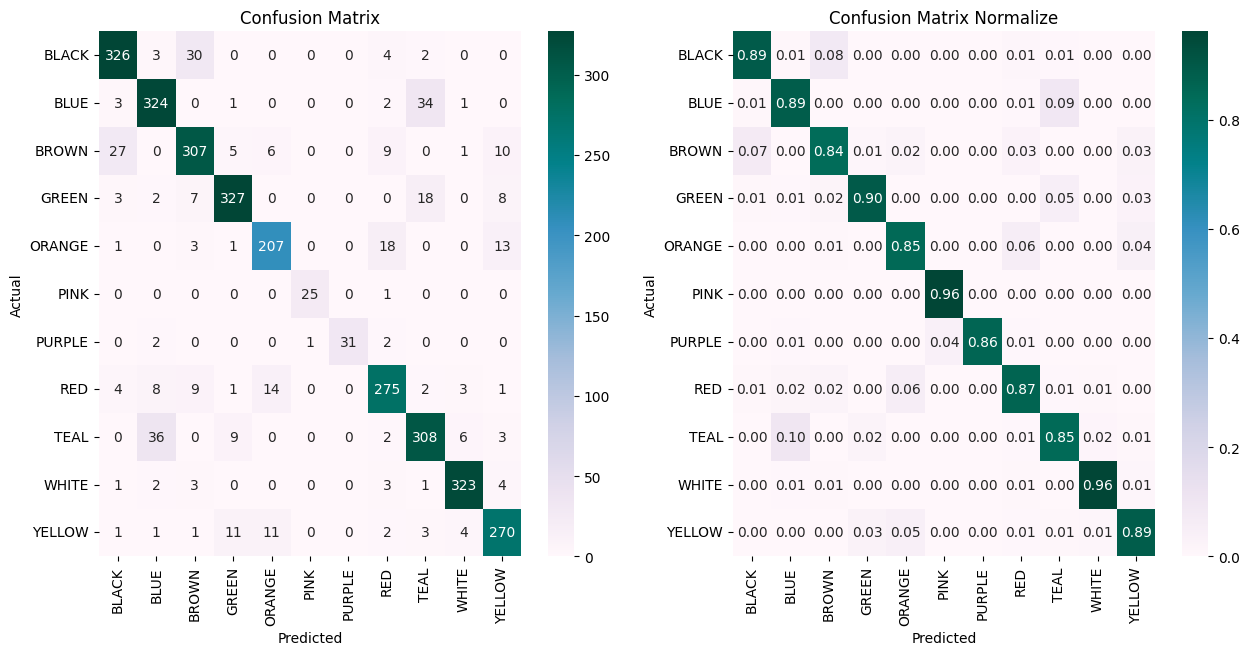

In [187]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm_model.predict(X_test)
cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred),labels=categories)
cm_normalize = cm / cm.astype(np.float).sum(axis=1)
cm_options= [{'data':cm,'title':'Confusion Matrix','format':'g'},{'data':cm_normalize,'title':'Confusion Matrix Normalize','format':'.2f'}]


plt.figure(figsize=(15, 15))
plt.rc('font', size=10) 
for i,opt in enumerate(cm_options):
    cm_df = pd.DataFrame(opt['data'],columns=categories,index=categories)
    print(i)
    plt.subplot(2, 2, i+1)   
    
    plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt=opt['format'])
    plot.set(title=opt['title'])
    plot.set(xlabel='Predicted', ylabel='Actual')
    
